<a href="https://colab.research.google.com/github/IsidoraJevremovic/osnovi-astronomije/blob/main/testiranje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━

First few rows of the data:
    time        mag  magerr
0     1  21.836027    0.05
1    11  21.829988    0.05
2    21  21.828557    0.05
3    31  21.828204    0.05
4    41  21.823229    0.05

Data types:
 time        int64
mag       float64
magerr    float64
dtype: object
Epoch [500/8000], Loss: 0.0313
Epoch [1000/8000], Loss: 0.0218
Epoch [1500/8000], Loss: 0.0228
Epoch [2000/8000], Loss: 0.0107
Epoch [2500/8000], Loss: 0.0065
Epoch [3000/8000], Loss: 0.0047
Epoch [3500/8000], Loss: 0.0035
Epoch [4000/8000], Loss: 0.0027
Epoch [4500/8000], Loss: 0.0048
Epoch [5000/8000], Loss: 0.0027
Epoch [5500/8000], Loss: 0.0013
Epoch [6000/8000], Loss: 0.0009
Epoch [6500/8000], Loss: 0.0059
Epoch [7000/8000], Loss: 0.0009
Epoch [7500/8000], Loss: 0.0010
Epoch [8000/8000], Loss: 0.0007
Mean Absolute Error (MAE): 0.0235


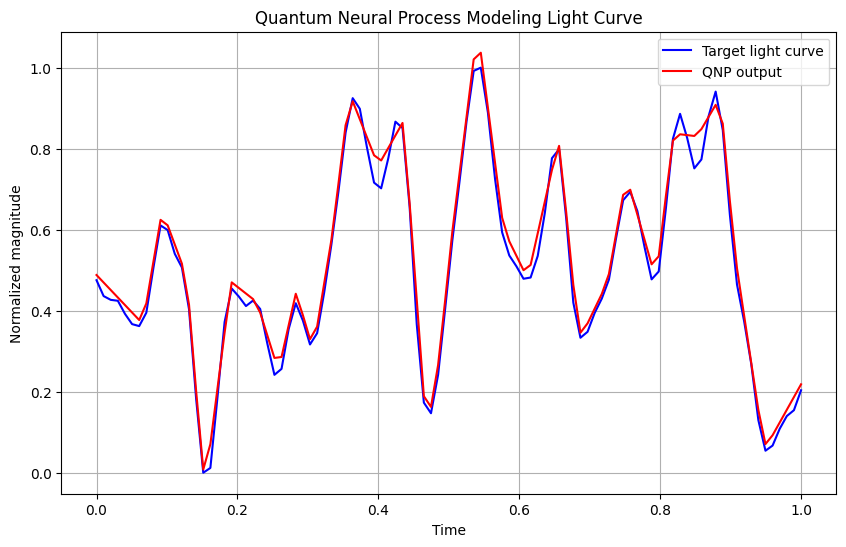

In [2]:
import cirq
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import random

num_qubits = 4
depth = 4
qubits = cirq.LineQubit.range(num_qubits)

def create_circuit(params):
    circuit = cirq.Circuit()
    index = 0
    for layer in range(depth):
        for i in range(num_qubits):
            circuit.append(cirq.rx(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.ry(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.rz(params[index])(qubits[i]))
            index += 1
        if num_qubits > 1:
            for i in range(num_qubits - 1):
                circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    return circuit

def simulate_circuit(circuit):
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    final_state = result.final_state_vector
    return np.real(final_state)

class QuantumEncoder(nn.Module):
    def __init__(self, num_qubits, depth, latent_dim):
        super(QuantumEncoder, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.latent_dim = latent_dim
        self.num_params = num_qubits * depth * 3
        self.params = nn.Parameter(torch.randn(self.num_params, dtype=torch.float32))

    def forward(self, x_context, y_context):
        params = self.params.detach().numpy()
        circuit = create_circuit(params)
        r = simulate_circuit(circuit)
        r = torch.tensor(r[:self.latent_dim], dtype=torch.float32)
        return r

class NeuralDecoder(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, hidden_dim=128):
        super(NeuralDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dim + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_target, r_target):
        decoder_input = torch.cat([x_target, r_target], dim=-1)
        y_pred = self.decoder(decoder_input)
        return y_pred

class QuantumNeuralProcess(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, depth, num_qubits):
        super(QuantumNeuralProcess, self).__init__()
        self.encoder = QuantumEncoder(num_qubits, depth, latent_dim)
        self.decoder = NeuralDecoder(input_dim, latent_dim, output_dim)

    def forward(self, x_context, y_context, x_target):
        r = self.encoder(x_context, y_context)
        r_target = r.expand(x_target.size(0), -1)
        y_pred = self.decoder(x_target, r_target)
        return y_pred

# Load and normalize the data
# data = pd.read_csv("6.csv", header=None, names=['time', 'mag', 'magerr'])

## Dodala funkciju za ucitavanje i proveru formata podataka, mozda nam format fajla ne odgovara -Isidora

def load_and_preprocess_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, header=None, names=['time', 'mag', 'magerr'], sep=' ')

    # Display the first few rows of the dataframe and check data types
    print("First few rows of the data:\n", data.head())
    print("\nData types:\n", data.dtypes)

    # Convert columns to numeric, forcing errors to NaN
    data['time'] = pd.to_numeric(data['time'], errors='coerce')
    data['mag'] = pd.to_numeric(data['mag'], errors='coerce')
    data['magerr'] = pd.to_numeric(data['magerr'], errors='coerce')

    # Drop rows with NaN values
    data.dropna(inplace=True)

    # Check if the DataFrame is empty after cleaning
    if data.empty:
        raise ValueError("After cleaning, data is empty. Check input data and preprocessing steps.")

    return data

data = load_and_preprocess_data("6.csv")
time_points = data['time'].values
magnitude = data['mag'].values

# Normalize the time points and magnitude
time_points = (time_points - np.min(time_points)) / (np.max(time_points) - np.min(time_points))
magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) - np.min(magnitude))

x_context = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_context = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)
x_target = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_target = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)

input_dim = 1
latent_dim = 4
output_dim = 1

qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context, y_context, x_target)
    loss = loss_fn(y_pred, y_target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

qnp_model.eval()
with torch.no_grad():
    y_pred = qnp_model(x_context, y_context, x_target).numpy()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_target.numpy(), y_pred)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(time_points, magnitude, label='Target light curve', color='blue')
plt.plot(time_points, y_pred, label='QNP output', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve')
plt.grid(True)
plt.show()


In [3]:
!pip install torchsummary

In [6]:
def remove_random_datapoints(data, percent):
    number_of_rows = data.shape[0]
    rows_to_remove = random.sample(range(number_of_rows), int(percent * number_of_rows / 100))
    return data.drop(rows_to_remove).reset_index(drop=True)


In [7]:
# Ukloni 10% podataka
data_90 = remove_random_datapoints(data, 10)

# Priprema podataka za treniranje modela
time_points_90 = data_90['time'].values
magnitude_90 = data_90['mag'].values

# Normalizacija podataka
time_points_90 = (time_points_90 - np.min(time_points_90)) / (np.max(time_points_90) - np.min(time_points_90))
magnitude_90 = (magnitude_90 - np.min(magnitude_90)) / (np.max(magnitude_90) - np.min(magnitude_90))

x_context_90 = torch.tensor(time_points_90, dtype=torch.float32).unsqueeze(-1)
y_context_90 = torch.tensor(magnitude_90, dtype=torch.float32).unsqueeze(-1)
x_target_90 = torch.tensor(time_points_90, dtype=torch.float32).unsqueeze(-1)
y_target_90 = torch.tensor(magnitude_90, dtype=torch.float32).unsqueeze(-1)

In [8]:
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_90, y_context_90, x_target_90)
    loss = loss_fn(y_pred, y_target_90)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

qnp_model.eval()
with torch.no_grad():
    y_pred_90 = qnp_model(x_context_90, y_context_90, x_target_90).numpy()

# Izračunavanje MAE
mae_90 = mean_absolute_error(y_target_90.numpy(), y_pred_90)
print(f'Mean Absolute Error (MAE) with 90% data: {mae_90:.4f}')


Epoch [500/8000], Loss: 0.0200
Epoch [1000/8000], Loss: 0.0137
Epoch [1500/8000], Loss: 0.0092
Epoch [2000/8000], Loss: 0.0082
Epoch [2500/8000], Loss: 0.0076
Epoch [3000/8000], Loss: 0.0069
Epoch [3500/8000], Loss: 0.0068
Epoch [4000/8000], Loss: 0.0045
Epoch [4500/8000], Loss: 0.0034
Epoch [5000/8000], Loss: 0.0030
Epoch [5500/8000], Loss: 0.0027
Epoch [6000/8000], Loss: 0.0030
Epoch [6500/8000], Loss: 0.0024
Epoch [7000/8000], Loss: 0.0043
Epoch [7500/8000], Loss: 0.0028
Epoch [8000/8000], Loss: 0.0033
Mean Absolute Error (MAE) with 90% data: 0.0455


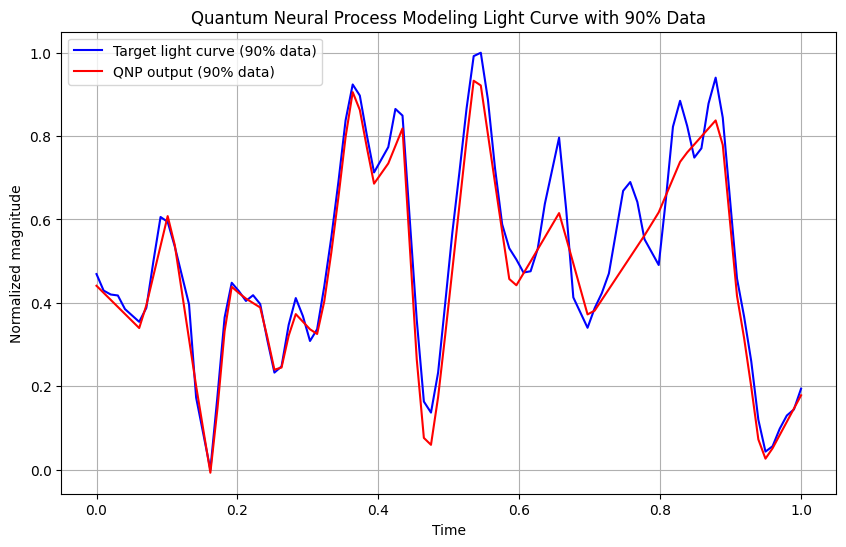

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(time_points_90, magnitude_90, label='Target light curve (90% data)', color='blue')
plt.plot(time_points_90, y_pred_90, label='QNP output (90% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 90% Data')
plt.grid(True)
plt.show()


Epoch [500/8000], Loss: 0.0198
Epoch [1000/8000], Loss: 0.0194
Epoch [1500/8000], Loss: 0.0146
Epoch [2000/8000], Loss: 0.0118
Epoch [2500/8000], Loss: 0.0080
Epoch [3000/8000], Loss: 0.0054
Epoch [3500/8000], Loss: 0.0049
Epoch [4000/8000], Loss: 0.0031
Epoch [4500/8000], Loss: 0.0268
Epoch [5000/8000], Loss: 0.0013
Epoch [5500/8000], Loss: 0.0013
Epoch [6000/8000], Loss: 0.0007
Epoch [6500/8000], Loss: 0.0007
Epoch [7000/8000], Loss: 0.0007
Epoch [7500/8000], Loss: 0.0005
Epoch [8000/8000], Loss: 0.0008
Mean Absolute Error (MAE) with 80% data: 0.0195


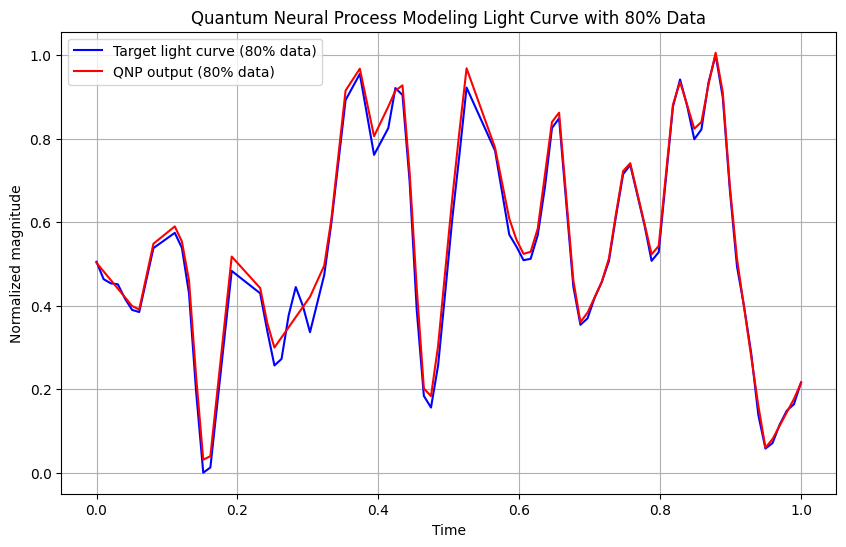

In [16]:
# Sada ponovo ukloni 10% podataka iz već redukovanih podataka (90%) da ostane 79.2% pocetnih
data_80 = remove_random_datapoints(data_90, 12)

# Priprema podataka za treniranje modela
time_points_80 = data_80['time'].values
magnitude_80 = data_80['mag'].values

# Normalizacija podataka
time_points_80 = (time_points_80 - np.min(time_points_80)) / (np.max(time_points_80) - np.min(time_points_80))
magnitude_80 = (magnitude_80 - np.min(magnitude_80)) / (np.max(magnitude_80) - np.min(magnitude_80))

x_context_80 = torch.tensor(time_points_80, dtype=torch.float32).unsqueeze(-1)
y_context_80 = torch.tensor(magnitude_80, dtype=torch.float32).unsqueeze(-1)
x_target_80 = torch.tensor(time_points_80, dtype=torch.float32).unsqueeze(-1)
y_target_80 = torch.tensor(magnitude_80, dtype=torch.float32).unsqueeze(-1)

# Kreiraj i treniraj model
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_80, y_context_80, x_target_80)
    loss = loss_fn(y_pred, y_target_80)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluacija modela i prikaz rezultata
qnp_model.eval()
with torch.no_grad():
    y_pred_80 = qnp_model(x_context_80, y_context_80, x_target_80).numpy()

# Izračunavanje MAE
mae_80 = mean_absolute_error(y_target_80.numpy(), y_pred_80)
print(f'Mean Absolute Error (MAE) with 80% data: {mae_80:.4f}')

# Prikazivanje grafika
plt.figure(figsize=(10, 6))
plt.plot(time_points_80, magnitude_80, label='Target light curve (80% data)', color='blue')
plt.plot(time_points_80, y_pred_80, label='QNP output (80% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 80% Data')
plt.grid(True)
plt.show()


Epoch [500/8000], Loss: 0.0254
Epoch [1000/8000], Loss: 0.0149
Epoch [1500/8000], Loss: 0.0117
Epoch [2000/8000], Loss: 0.0107
Epoch [2500/8000], Loss: 0.0083
Epoch [3000/8000], Loss: 0.0077
Epoch [3500/8000], Loss: 0.0063
Epoch [4000/8000], Loss: 0.0074
Epoch [4500/8000], Loss: 0.0057
Epoch [5000/8000], Loss: 0.0050
Epoch [5500/8000], Loss: 0.0059
Epoch [6000/8000], Loss: 0.0035
Epoch [6500/8000], Loss: 0.0023
Epoch [7000/8000], Loss: 0.0061
Epoch [7500/8000], Loss: 0.0034
Epoch [8000/8000], Loss: 0.0006
Mean Absolute Error (MAE) with 70% data: 0.0147


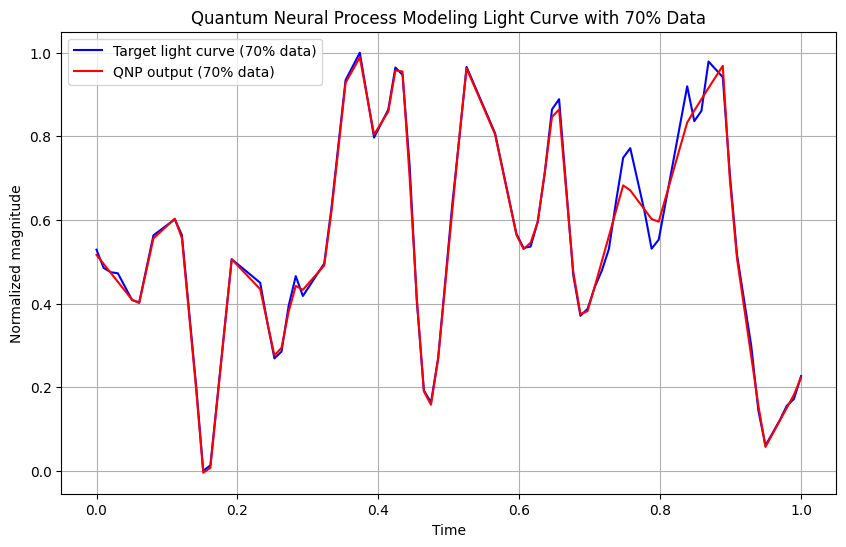

In [17]:
# Ukloni dodatnih 10% da ostane 69.7%
data_70 = remove_random_datapoints(data_80, 12)

# Priprema podataka za treniranje modela
time_points_70 = data_70['time'].values
magnitude_70 = data_70['mag'].values

# Normalizacija podataka
time_points_70 = (time_points_70 - np.min(time_points_70)) / (np.max(time_points_70) - np.min(time_points_70))
magnitude_70 = (magnitude_70 - np.min(magnitude_70)) / (np.max(magnitude_70) - np.min(magnitude_70))

x_context_70 = torch.tensor(time_points_70, dtype=torch.float32).unsqueeze(-1)
y_context_70 = torch.tensor(magnitude_70, dtype=torch.float32).unsqueeze(-1)
x_target_70 = torch.tensor(time_points_70, dtype=torch.float32).unsqueeze(-1)
y_target_70 = torch.tensor(magnitude_70, dtype=torch.float32).unsqueeze(-1)

# Kreiraj i treniraj model
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_70, y_context_70, x_target_70)
    loss = loss_fn(y_pred, y_target_70)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluacija modela i prikaz rezultata
qnp_model.eval()
with torch.no_grad():
    y_pred_70 = qnp_model(x_context_70, y_context_70, x_target_70).numpy()

# Izračunavanje MAE
mae_70 = mean_absolute_error(y_target_70.numpy(), y_pred_70)
print(f'Mean Absolute Error (MAE) with 70% data: {mae_70:.4f}')

# Prikazivanje grafika
plt.figure(figsize=(10, 6))
plt.plot(time_points_70, magnitude_70, label='Target light curve (70% data)', color='blue')
plt.plot(time_points_70, y_pred_70, label='QNP output (70% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 70% Data')
plt.grid(True)
plt.show()


Epoch [500/8000], Loss: 0.0238
Epoch [1000/8000], Loss: 0.0198
Epoch [1500/8000], Loss: 0.0187
Epoch [2000/8000], Loss: 0.0128
Epoch [2500/8000], Loss: 0.0090
Epoch [3000/8000], Loss: 0.0077
Epoch [3500/8000], Loss: 0.0078
Epoch [4000/8000], Loss: 0.0047
Epoch [4500/8000], Loss: 0.0021
Epoch [5000/8000], Loss: 0.0029
Epoch [5500/8000], Loss: 0.0012
Epoch [6000/8000], Loss: 0.0007
Epoch [6500/8000], Loss: 0.0009
Epoch [7000/8000], Loss: 0.0011
Epoch [7500/8000], Loss: 0.0008
Epoch [8000/8000], Loss: 0.0010
Mean Absolute Error (MAE) with 60% data: 0.0255


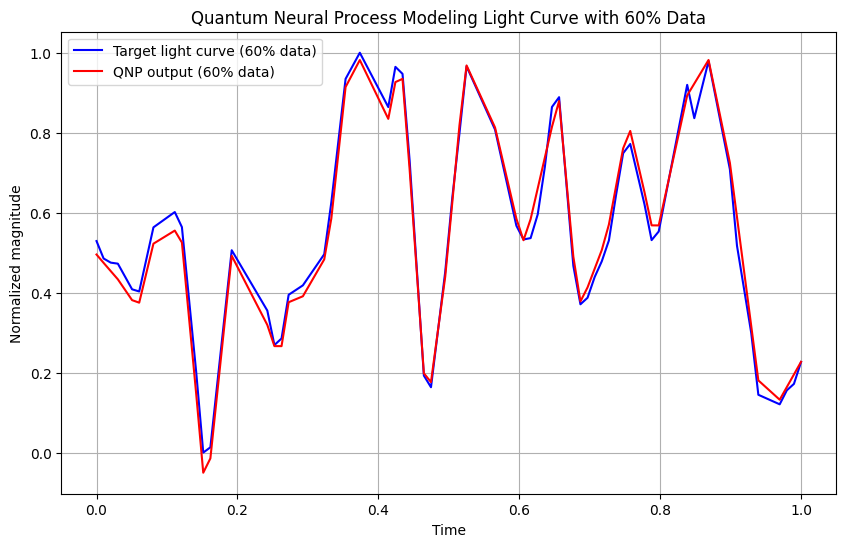

In [18]:
# Ukloni 10% podataka da ostane 61.3%
data_60 = remove_random_datapoints(data_70, 12)

# Priprema podataka za treniranje modela
time_points_60 = data_60['time'].values
magnitude_60 = data_60['mag'].values

# Normalizacija podataka
time_points_60 = (time_points_60 - np.min(time_points_60)) / (np.max(time_points_60) - np.min(time_points_60))
magnitude_60 = (magnitude_60 - np.min(magnitude_60)) / (np.max(magnitude_60) - np.min(magnitude_60))

x_context_60 = torch.tensor(time_points_60, dtype=torch.float32).unsqueeze(-1)
y_context_60 = torch.tensor(magnitude_60, dtype=torch.float32).unsqueeze(-1)
x_target_60 = torch.tensor(time_points_60, dtype=torch.float32).unsqueeze(-1)
y_target_60 = torch.tensor(magnitude_60, dtype=torch.float32).unsqueeze(-1)

# Kreiraj i treniraj model
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_60, y_context_60, x_target_60)
    loss = loss_fn(y_pred, y_target_60)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluacija modela i prikaz rezultata
qnp_model.eval()
with torch.no_grad():
    y_pred_60 = qnp_model(x_context_60, y_context_60, x_target_60).numpy()

# Izračunavanje MAE
mae_60 = mean_absolute_error(y_target_60.numpy(), y_pred_60)
print(f'Mean Absolute Error (MAE) with 60% data: {mae_60:.4f}')

# Prikazivanje grafika
plt.figure(figsize=(10, 6))
plt.plot(time_points_60, magnitude_60, label='Target light curve (60% data)', color='blue')
plt.plot(time_points_60, y_pred_60, label='QNP output (60% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 60% Data')
plt.grid(True)
plt.show()


Epoch [500/8000], Loss: 0.0226
Epoch [1000/8000], Loss: 0.0128
Epoch [1500/8000], Loss: 0.0102
Epoch [2000/8000], Loss: 0.0095
Epoch [2500/8000], Loss: 0.0079
Epoch [3000/8000], Loss: 0.0066
Epoch [3500/8000], Loss: 0.0048
Epoch [4000/8000], Loss: 0.0067
Epoch [4500/8000], Loss: 0.0042
Epoch [5000/8000], Loss: 0.0028
Epoch [5500/8000], Loss: 0.0026
Epoch [6000/8000], Loss: 0.0023
Epoch [6500/8000], Loss: 0.0024
Epoch [7000/8000], Loss: 0.0068
Epoch [7500/8000], Loss: 0.0022
Epoch [8000/8000], Loss: 0.0018
Mean Absolute Error (MAE) with 50% data: 0.0326


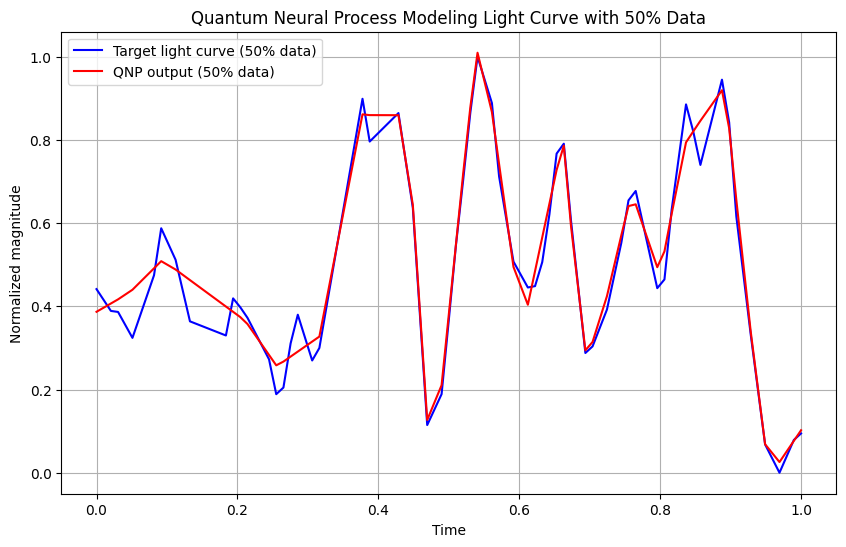

In [15]:
# Ukloni 10% podataka da ostane 54%
data_50 = remove_random_datapoints(data_60, 12)

# Priprema podataka za treniranje modela
time_points_50 = data_50['time'].values
magnitude_50 = data_50['mag'].values

# Normalizacija podataka
time_points_50 = (time_points_50 - np.min(time_points_50)) / (np.max(time_points_50) - np.min(time_points_50))
magnitude_50 = (magnitude_50 - np.min(magnitude_50)) / (np.max(magnitude_50) - np.min(magnitude_50))

x_context_50 = torch.tensor(time_points_50, dtype=torch.float32).unsqueeze(-1)
y_context_50 = torch.tensor(magnitude_50, dtype=torch.float32).unsqueeze(-1)
x_target_50 = torch.tensor(time_points_50, dtype=torch.float32).unsqueeze(-1)
y_target_50 = torch.tensor(magnitude_50, dtype=torch.float32).unsqueeze(-1)

# Kreiraj i treniraj model
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_50, y_context_50, x_target_50)
    loss = loss_fn(y_pred, y_target_50)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluacija modela i prikaz rezultata
qnp_model.eval()
with torch.no_grad():
    y_pred_50 = qnp_model(x_context_50, y_context_50, x_target_50).numpy()

# Izračunavanje MAE
mae_50 = mean_absolute_error(y_target_50.numpy(), y_pred_50)
print(f'Mean Absolute Error (MAE) with 50% data: {mae_50:.4f}')

# Prikazivanje grafika
plt.figure(figsize=(10, 6))
plt.plot(time_points_50, magnitude_50, label='Target light curve (50% data)', color='blue')
plt.plot(time_points_50, y_pred_50, label='QNP output (50% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 50% Data')
plt.grid(True)
plt.show()


In [ ]:
# Ukloni 10% podataka da ostane 43.2%
data_40 = remove_random_datapoints(data_50, 20)

# Priprema podataka za treniranje modela
time_points_40 = data_40['time'].values
magnitude_40 = data_40['mag'].values

# Normalizacija podataka
time_points_40 = (time_points_40 - np.min(time_points_40)) / (np.max(time_points_40) - np.min(time_points_40))
magnitude_40 = (magnitude_40 - np.min(magnitude_40)) / (np.max(magnitude_40) - np.min(magnitude_40))

x_context_40 = torch.tensor(time_points_40, dtype=torch.float32).unsqueeze(-1)
y_context_40 = torch.tensor(magnitude_40, dtype=torch.float32).unsqueeze(-1)
x_target_40 = torch.tensor(time_points_40, dtype=torch.float32).unsqueeze(-1)
y_target_40 = torch.tensor(magnitude_40, dtype=torch.float32).unsqueeze(-1)

# Kreiraj i treniraj model
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_40, y_context_40, x_target_40)
    loss = loss_fn(y_pred, y_target_40)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluacija modela i prikaz rezultata
qnp_model.eval()
with torch.no_grad():
    y_pred_40 = qnp_model(x_context_40, y_context_40, x_target_40).numpy()

# Izračunavanje MAE
mae_40 = mean_absolute_error(y_target_40.numpy(), y_pred_40)
print(f'Mean Absolute Error (MAE) with 40% data: {mae_40:.4f}')

# Prikazivanje grafika
plt.figure(figsize=(10, 6))
plt.plot(time_points_40, magnitude_40, label='Target light curve (40% data)', color='blue')
plt.plot(time_points_40, y_pred_40, label='QNP output (40% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 40% Data')
plt.grid(True)
plt.show()


Epoch [500/8000], Loss: 0.0337
Epoch [1000/8000], Loss: 0.0178
Epoch [1500/8000], Loss: 0.0119
Epoch [2000/8000], Loss: 0.0050
Epoch [2500/8000], Loss: 0.0030
Epoch [3000/8000], Loss: 0.0019
Epoch [3500/8000], Loss: 0.0050
Epoch [4000/8000], Loss: 0.0021
Epoch [4500/8000], Loss: 0.0011
Epoch [5000/8000], Loss: 0.0010
Epoch [5500/8000], Loss: 0.0010
Epoch [6000/8000], Loss: 0.0017


In [ ]:
# Ukloni 10% podataka da ostane 32.4%
data_30 = remove_random_datapoints(data_40, 25)

# Priprema podataka za treniranje modela
time_points_30 = data_30['time'].values
magnitude_30 = data_30['mag'].values

# Normalizacija podataka
time_points_30 = (time_points_30 - np.min(time_points_30)) / (np.max(time_points_30) - np.min(time_points_30))
magnitude_30 = (magnitude_30 - np.min(magnitude_30)) / (np.max(magnitude_30) - np.min(magnitude_30))

x_context_30 = torch.tensor(time_points_30, dtype=torch.float32).unsqueeze(-1)
y_context_30 = torch.tensor(magnitude_30, dtype=torch.float32).unsqueeze(-1)
x_target_30 = torch.tensor(time_points_30, dtype=torch.float32).unsqueeze(-1)
y_target_30 = torch.tensor(magnitude_30, dtype=torch.float32).unsqueeze(-1)

# Kreiraj i treniraj model
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_30, y_context_30, x_target_30)
    loss = loss_fn(y_pred, y_target_30)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluacija modela i prikaz rezultata
qnp_model.eval()
with torch.no_grad():
    y_pred_30 = qnp_model(x_context_30, y_context_30, x_target_30).numpy()

# Izračunavanje MAE
mae_30 = mean_absolute_error(y_target_30.numpy(), y_pred_30)
print(f'Mean Absolute Error (MAE) with 30% data: {mae_30:.4f}')

# Prikazivanje grafika
plt.figure(figsize=(10, 6))
plt.plot(time_points_30, magnitude_30, label='Target light curve (30% data)', color='blue')
plt.plot(time_points_30, y_pred_30, label='QNP output (30% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 30% Data')
plt.grid(True)
plt.show()


In [ ]:
# Ukloni 10% podataka da ostane 22.7%
data_20 = remove_random_datapoints(data_30, 30)

# Priprema podataka za treniranje modela
time_points_20 = data_20['time'].values
magnitude_20 = data_20['mag'].values

# Normalizacija podataka
time_points_20 = (time_points_20 - np.min(time_points_20)) / (np.max(time_points_20) - np.min(time_points_20))
magnitude_20 = (magnitude_20 - np.min(magnitude_20)) / (np.max(magnitude_20) - np.min(magnitude_20))

x_context_20 = torch.tensor(time_points_20, dtype=torch.float32).unsqueeze(-1)
y_context_20 = torch.tensor(magnitude_20, dtype=torch.float32).unsqueeze(-1)
x_target_20 = torch.tensor(time_points_20, dtype=torch.float32).unsqueeze(-1)
y_target_20 = torch.tensor(magnitude_20, dtype=torch.float32).unsqueeze(-1)

# Kreiraj i treniraj model
qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context_20, y_context_20, x_target_20)
    loss = loss_fn(y_pred, y_target_20)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluacija modela i prikaz rezultata
qnp_model.eval()
with torch.no_grad():
    y_pred_20 = qnp_model(x_context_20, y_context_20, x_target_20).numpy()

# Izračunavanje MAE
mae_20 = mean_absolute_error(y_target_20.numpy(), y_pred_20)
print(f'Mean Absolute Error (MAE) with 20% data: {mae_20:.4f}')

# Prikazivanje grafika
plt.figure(figsize=(10, 6))
plt.plot(time_points_20, magnitude_20, label='Target light curve (20% data)', color='blue')
plt.plot(time_points_20, y_pred_20, label='QNP output (20% data)', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with 20% Data')
plt.grid(True)
plt.show()



Testing with 90% of data:
Mean Absolute Error (MAE) with 90% data: 0.0425

Testing with 80% of data:
Mean Absolute Error (MAE) with 80% data: 0.0354

Testing with 70% of data:
Mean Absolute Error (MAE) with 70% data: 0.0148

Testing with 60% of data:
Mean Absolute Error (MAE) with 60% data: 0.0188

Testing with 50% of data:
Mean Absolute Error (MAE) with 50% data: 0.0409

Testing with 40% of data:
Mean Absolute Error (MAE) with 40% data: 0.0183

Testing with 30% of data:
Mean Absolute Error (MAE) with 30% data: 0.0149

Testing with 20% of data:
Mean Absolute Error (MAE) with 20% data: 0.0057

Testing with 10% of data:
Mean Absolute Error (MAE) with 10% data: 0.0263


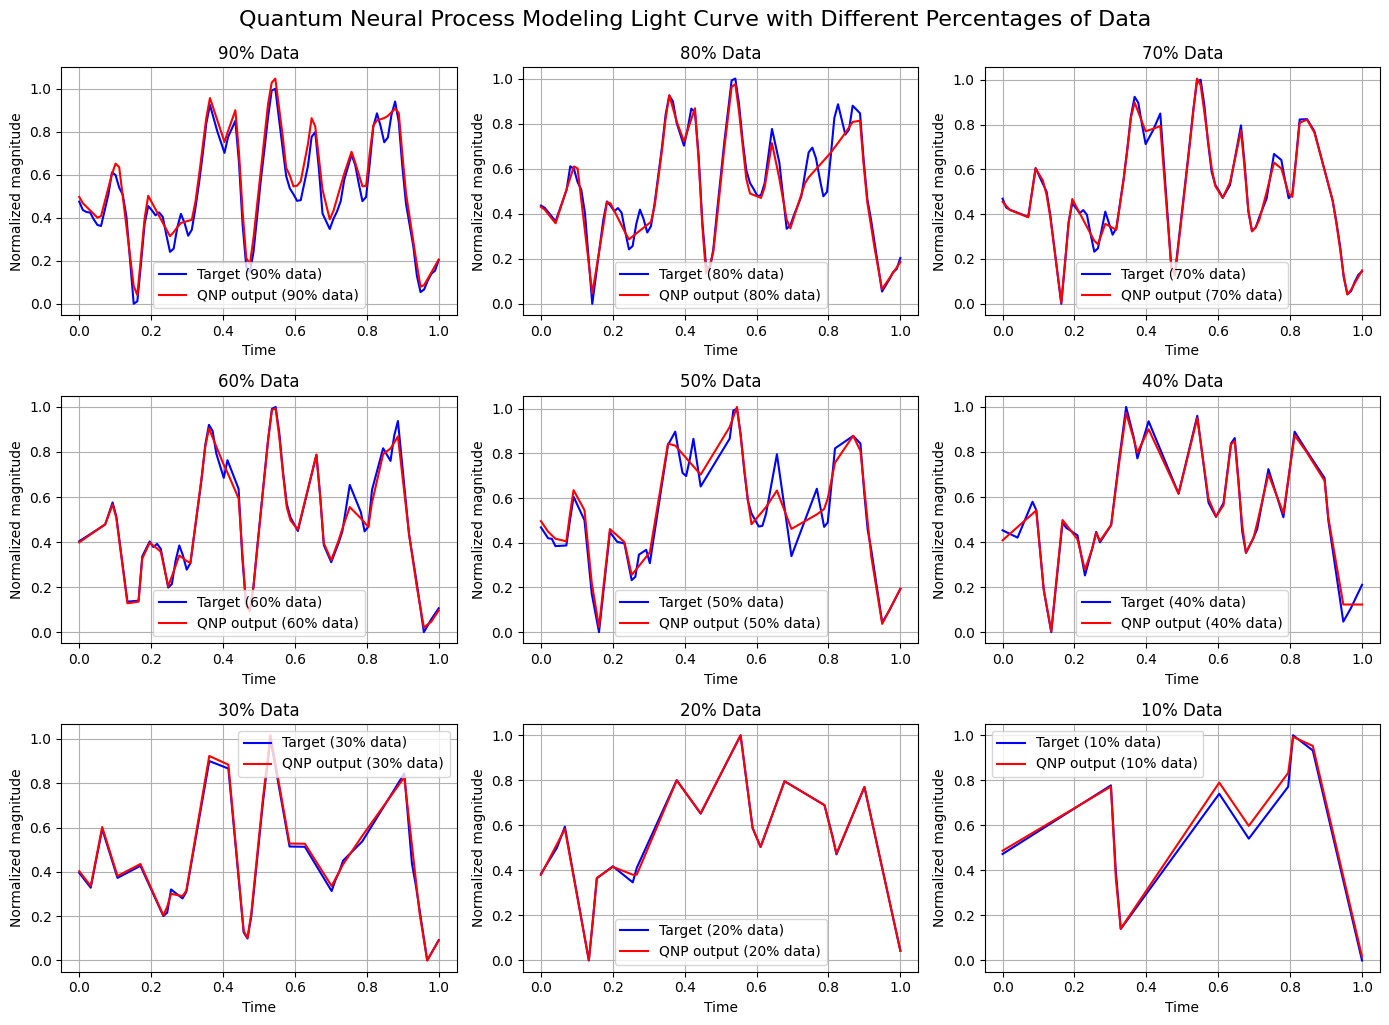

In [11]:
# Lista procenta podataka koja se zadržava
percentages = [90, 80, 70, 60, 50, 40, 30, 20, 10]

# Funkcija za treniranje i evaluaciju modela sa datim procentom podataka
def train_and_evaluate_with_percent(data, percent):
    data_reduced = remove_random_datapoints(data, 100 - percent)

    time_points_reduced = data_reduced['time'].values
    magnitude_reduced = data_reduced['mag'].values

    # Normalizacija podataka
    time_points_reduced = (time_points_reduced - np.min(time_points_reduced)) / (np.max(time_points_reduced) - np.min(time_points_reduced))
    magnitude_reduced = (magnitude_reduced - np.min(magnitude_reduced)) / (np.max(magnitude_reduced) - np.min(magnitude_reduced))

    x_context_reduced = torch.tensor(time_points_reduced, dtype=torch.float32).unsqueeze(-1)
    y_context_reduced = torch.tensor(magnitude_reduced, dtype=torch.float32).unsqueeze(-1)
    x_target_reduced = torch.tensor(time_points_reduced, dtype=torch.float32).unsqueeze(-1)
    y_target_reduced = torch.tensor(magnitude_reduced, dtype=torch.float32).unsqueeze(-1)

    qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
    optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
    loss_fn = nn.MSELoss()

    num_epochs = 8000
    for epoch in range(num_epochs):
        qnp_model.train()
        optimizer.zero_grad()
        y_pred = qnp_model(x_context_reduced, y_context_reduced, x_target_reduced)
        loss = loss_fn(y_pred, y_target_reduced)
        loss.backward()
        optimizer.step()

    qnp_model.eval()
    with torch.no_grad():
        y_pred_reduced = qnp_model(x_context_reduced, y_context_reduced, x_target_reduced).numpy()

    # Izračunavanje MAE
    mae_reduced = mean_absolute_error(y_target_reduced.numpy(), y_pred_reduced)
    print(f'Mean Absolute Error (MAE) with {percent}% data: {mae_reduced:.4f}')

    # Povratak rezultata za grafik
    return time_points_reduced, magnitude_reduced, y_pred_reduced

# Iteracija kroz različite procente podataka i pravljenje grafika
plt.figure(figsize=(14, 10))

for i, percent in enumerate(percentages, 1):
    print(f'\nTesting with {percent}% of data:')
    time_points_reduced, magnitude_reduced, y_pred_reduced = train_and_evaluate_with_percent(data, percent)

    plt.subplot(3, 3, i)  # 3x3 grid, i-th subplot
    plt.plot(time_points_reduced, magnitude_reduced, label=f'Target ({percent}% data)', color='blue')
    plt.plot(time_points_reduced, y_pred_reduced, label=f'QNP output ({percent}% data)', color='red')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Normalized magnitude')
    plt.title(f'{percent}% Data')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Quantum Neural Process Modeling Light Curve with Different Percentages of Data', fontsize=16, y=1.02)
plt.show()
